<a href="https://colab.research.google.com/github/torrhen/pytorch/blob/main/03_pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import pytorch
import torch
from torch import nn
print(f"pytorch version: {torch.__version__}")

pytorch version: 1.12.1+cu113


In [2]:
# first model is trained on the cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
print(f"torchvision version: {torchvision.__version__}") 

torchvision version: 0.13.1+cu113


In [4]:
# install torchmetrics from evaluating models
!pip install torchmetrics
from torchmetrics import Accuracy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# import matplotlib
import matplotlib.pyplot as plt

In [6]:
# import fashion MNIST training data
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(), target_transform=None)

In [7]:
# dataset information
print(f"Number of training instances: {len(train_data.data)}")
print(f"Number of training targets: {len(train_data.targets)}")
print(f"Number of test instances: {len(test_data.data)}")
print(f"Number of test targets: {len(test_data.targets)}")
print(f"Number of classes: {len(train_data.classes)}")
print(train_data.classes)

Number of training instances: 60000
Number of training targets: 60000
Number of test instances: 10000
Number of test targets: 10000
Number of classes: 10
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


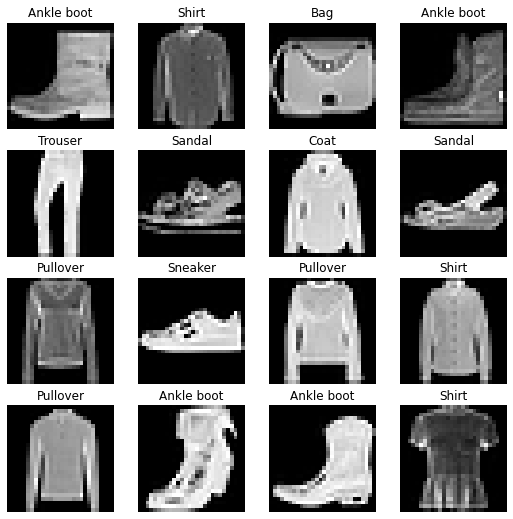

In [8]:
# display 12 random images from the training set
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  # create a random scalar tensor index
  random_idx = torch.randint(0, len(train_data), size=[1]).item() # item() to convert integer tensor to scalar
  image, label = train_data[random_idx] # choose random data pair from data set
  fig.add_subplot(rows, cols, i) # subplots are non-zero indexed
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(train_data.classes[label])
  plt.axis(False)

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# divide the data sets into batches stored in data loaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE)

print(f"Number of batches for training data: {len(train_loader)}") # 32 * 1875 = 60000
print(f"Number of batches for test data: {len(test_loader)}")


Number of batches for training data: 1875
Number of batches for test data: 313


In [10]:
# get next training batch from data loader
train_image_batch, train_label_batch = next(iter(train_loader))
print(f"training image batch size: {train_image_batch.shape}")
print(f"training label batch size: {train_label_batch.shape}")

training image batch size: torch.Size([32, 1, 28, 28])
training label batch size: torch.Size([32])


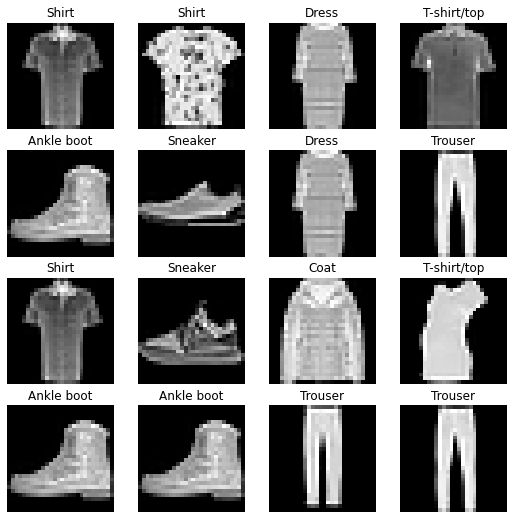

In [11]:
# display 12 random images from the first training set batch of the data loader
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  # create a random scalar tensor index
  random_idx = torch.randint(0, len(train_image_batch), size=[1]).item()
  image, label = train_image_batch[random_idx], train_label_batch[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(train_data.classes[label])
  plt.axis(False)

In [12]:
# simple linear model
class SimpleLinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Flatten()
    self.layer2 = nn.Linear(in_features=784, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=10)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

# instantiate model
torch.manual_seed(42)
model_1 = SimpleLinearModel().to(device)

In [13]:
# set up loss
loss_func = nn.CrossEntropyLoss()
# set up optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
# setup accuracy metric
accuracy_func = Accuracy().to(device)

In [14]:
torch.manual_seed(42)

epochs = 5

# loop epoch
for epoch in range(epochs):
  train_loss = 0
  train_acc = 0
  # loop each batch in the train data loader
  for batch, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device)

    model_1.train()
    # forward pass
    train_logits = model_1(X)
    train_labels = torch.argmax(torch.softmax(train_logits, dim=1), dim=1)
    
    # calculate loss
    loss = loss_func(train_logits, y)
    train_loss += loss
    train_acc += accuracy_func(train_labels, y)

    # zero grad
    optimizer.zero_grad()

    # back propagation
    loss.backward()

    # gradient descent
    optimizer.step()
  
  # calculate the average batch training loss for epoch
  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  # testing loop
  test_loss = 0
  test_acc = 0

  model_1.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_loader):
      X, y = X.to(device), y.to(device)
      
      test_logits = model_1(X)
      test_labels = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
      
      batch_test_loss = loss_func(test_logits, y)
      test_loss += batch_test_loss
      
      test_acc += accuracy_func(test_labels, y)

    # calculations on test metrics must happen within inference_mode()
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

  print(f"epoch: {epoch} | train loss: {train_loss:.5f} | train accuracy: {train_acc:.2f}% | test loss: {test_loss:.5f} | test accuracy {test_acc:.2f}%")


epoch: 0 | train loss: 0.59039 | train accuracy: 0.79% | test loss: 0.50954 | test accuracy 0.82%
epoch: 1 | train loss: 0.47633 | train accuracy: 0.83% | test loss: 0.47989 | test accuracy 0.83%
epoch: 2 | train loss: 0.45503 | train accuracy: 0.84% | test loss: 0.47664 | test accuracy 0.83%
epoch: 3 | train loss: 0.44251 | train accuracy: 0.84% | test loss: 0.46306 | test accuracy 0.84%
epoch: 4 | train loss: 0.43582 | train accuracy: 0.85% | test loss: 0.46869 | test accuracy 0.83%


In [15]:
# create model evaulate function for reuse
def evaluate_model(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, acc_fn, device: torch.device = device):
  # dataset metrics
  test_loss = 0
  test_acc = 0
  
  model.eval()
  with torch.inference_mode():
    # loop each batch of the test data
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # calculate batch outputs
      test_logits = model(X) 
      test_labels = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
      # calculate batch loss
      batch_test_loss = loss_fn(test_logits, y)
      # accumulate loss for dataset
      test_loss += batch_test_loss
      # accumulate accuacy for dataset
      test_acc += acc_fn(test_labels, y)

    # average batch results across entire dataset
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    # return dictionary of results
    return {'model name':model.__class__.__name__, 'model_loss':test_loss.item(), 'model_accuracy':test_acc.item() * 100}

In [16]:
model_1_results = evaluate_model(model_1, test_loader, loss_func, accuracy_func)
print(model_1_results)

{'model name': 'SimpleLinearModel', 'model_loss': 0.46869388222694397, 'model_accuracy': 83.26677083969116}


In [17]:
# simple non-linear model
class SimpleNonLinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Flatten()
    self.layer2 = nn.Linear(in_features=784, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=10)
    self.relu = nn.ReLU()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.relu(self.layer3(self.relu(self.layer2(self.layer1(x)))))

# instantiate model
torch.manual_seed(42)
model_2 = SimpleNonLinearModel().to(device)

In [18]:
# setup loss function
loss_func = nn.CrossEntropyLoss()
# setup optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
# setup accuracy metric
accuracy_func = Accuracy().to(device)

In [19]:
# create training step function for reuse
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, acc_fn, device: torch.device = device):
  train_loss, train_accuracy = 0, 0
  # loop batches
  for batch, (X, y) in enumerate(dataloader):
    # allocate batch to device
    X = X.to(device)
    y = y.to(device)

    model.train()
    # forward pass
    logits = model(X)
    # softmax for multi-class classification
    labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)

    # calculate and store loss
    loss = loss_fn(logits, y)
    train_loss += loss

    # calculate and store accuracy
    train_accuracy += acc_fn(labels, y)

    # zero grad
    optimizer.zero_grad()

    # back propagation
    loss.backward()

    # gradient descent
    optimizer.step()

  # average loss and accuracy for entire dataset
  train_loss /= len(dataloader)
  train_accuracy /= len(dataloader)

  print(f"train loss: {train_loss:.5f} | train_accuracy: {train_accuracy:.2f}%")

# create testing step function for reuse
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, acc_fn, device: torch.device = device):
  test_loss, test_accuracy = 0, 0

  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      # allocate data to device
      X, y = X.to(device), y.to(device)

      # forward pass
      logits = model(X)
      labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)

      # calculate and store loss
      loss = loss_fn(logits, y)
      test_loss += loss
      # calculate and store accuracy
      test_accuracy += acc_fn(labels, y)

    test_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f"test loss: {test_loss:.5f} | test accuracy: {test_accuracy:.2f}%")


In [20]:
epochs = 3
# train and test model using train and test function
for epoch in range(epochs):
  print(f"epoch: {epoch}")

  train_step(model_2, train_loader, loss_func, accuracy_func, device)
  test_step(model_2, test_loader, loss_func, accuracy_func, device)

epoch: 0
train loss: 1.05878 | train_accuracy: 0.62%
test loss: 0.99506 | test accuracy: 0.64%
epoch: 1
train loss: 0.91331 | train_accuracy: 0.66%
test loss: 0.90508 | test accuracy: 0.67%
epoch: 2
train loss: 0.87982 | train_accuracy: 0.67%
test loss: 0.89476 | test accuracy: 0.66%


In [21]:
model_2_results = evaluate_model(model_2, test_loader, loss_func, accuracy_func, device)
print(model_2_results)

{'model name': 'SimpleNonLinearModel', 'model_loss': 0.8947636485099792, 'model_accuracy': 66.46365523338318}


In [22]:
# custom convolutional network based on TinyVGG
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) # default stride is the same as the kernel size
    )
    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=10*7*7, out_features=10)
    )

  def forward(self, x):
    return self.fc(self.block2(self.block1(x)))

# instantiate model
torch.manual_seed(42)
model_3 = ConvolutionalNeuralNetwork().to(device)

In [23]:
# experiment with convolution layer
torch.manual_seed(42)

# [batch, channels, width, height]
x = torch.randn((3, 64 ,64)).unsqueeze(dim=0) # add single batch dimension
print(x.shape) # [1, 3, 64, 64]

conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)
print(conv_layer(x).shape) # [1, 10, 62, 62]

# new output shape = ({[n - k + 2p] / s} + 1, {[n - k + 2p] / s} + 1)

torch.Size([1, 3, 64, 64])
torch.Size([1, 10, 62, 62])


In [24]:
# experiment with max pooling layer
torch.manual_seed(42)

x = torch.randn((3, 64, 64)).unsqueeze(dim=0)
print(x.shape) # [1, 3, 64, 64]

max_pool = nn.MaxPool2d(kernel_size=2) # stride is same as kernel size by default
print(max_pool(x).shape) # [1, 3, 32, 32]

x = torch.randn((1, 2, 2)).unsqueeze(dim=0)
print(x)
print(x.shape)

y = max_pool(x)
print(y) # select the highest value in the 2x2 kernel
print(y.shape) # [1, 1, 1, 1]

torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 32, 32])
tensor([[[[ 0.7264, -0.4500],
          [ 0.4298,  0.3540]]]])
torch.Size([1, 1, 2, 2])
tensor([[[[0.7264]]]])
torch.Size([1, 1, 1, 1])


In [25]:
# experiment with average pooling
torch.manual_seed(42)

x = torch.randn((1, 2, 2)).unsqueeze(dim=0)
print(x)
print(x.shape) # [1, 1, 2, 2]

avg_pool = nn.AvgPool2d(kernel_size=2) # stride is the same as kernel size by default

y = avg_pool(x)
print(y) # select the average of all values within the kernel space
print(y) # [1, 1, 1, 1]

tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
torch.Size([1, 1, 2, 2])
tensor([[[[0.2326]]]])
tensor([[[[0.2326]]]])


In [26]:
# set up loss function
loss_func = nn.CrossEntropyLoss()
# set up optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)
# set up accuracy metric
accuracy = Accuracy().to(device)

In [27]:
# train and test loop
epochs = 3

for epoch in range(epochs):
  print(f"epoch: {epoch}")
  train_step(model_3, train_loader, loss_func, accuracy_func, device)
  test_step(model_3, test_loader, loss_func, accuracy_func, device)

epoch: 0
train loss: 0.58129 | train_accuracy: 0.79%
test loss: 0.44110 | test accuracy: 0.84%
epoch: 1
train loss: 0.35197 | train_accuracy: 0.87%
test loss: 0.35055 | test accuracy: 0.88%
epoch: 2
train loss: 0.31590 | train_accuracy: 0.89%
test loss: 0.32734 | test accuracy: 0.88%


In [28]:
# evaluate model 3 results
model_3_results = evaluate_model(model_3, test_loader, loss_func, accuracy_func, device)
print(model_3_results)

{'model name': 'ConvolutionalNeuralNetwork', 'model_loss': 0.3273375630378723, 'model_accuracy': 88.09903860092163}


In [29]:
# combine results of all three models
import pandas as pd
# create combined data frame
results = pd.DataFrame([model_1_results, model_2_results, model_3_results])
print(results)

                   model name  model_loss  model_accuracy
0           SimpleLinearModel    0.468694       83.266771
1        SimpleNonLinearModel    0.894764       66.463655
2  ConvolutionalNeuralNetwork    0.327338       88.099039
